In [1]:
# !pip install tqdm
# # !pip install optuna
# !pip install torchsummary

In [3]:
# Importing relevant packages
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

from project1_model import ResNet, BasicBlock


In [10]:
# fetching device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# parameters
num_workers = 10
batch_size = 128
learningRate = 0.01
weight_decay = 0.0005
res_blocks = [2,4,4,2]
num_res_layer = len(res_blocks)
kernel=(3,1)
skip_kernel=(3,1)
channels = 32

#### Mean and Standard Deviation for Cifar Dataset -

Mean: tensor([0.4914, 0.4822, 0.4465])

Standard deviation: tensor([0.2471, 0.2435, 0.2616])

In [11]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        #transforms.RandomRotation(degrees=(90)),
        transforms.RandomCrop(32, padding=4),
        #transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2471, 0.2435, 0.2616]),
        transforms.RandomErasing(),

    ]),
    'val': transforms.Compose([
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2471, 0.2435, 0.2616])
    ]),
}


dataloaders = {}
for phase in ['train','val']:
    dataset = datasets.CIFAR10(root='./data', train=(phase=='train'),download=True, transform=data_transforms[phase])
    dataloaders[phase] = torch.utils.data.DataLoader(dataset, batch_size=batch_size,shuffle=(phase=='train'), num_workers=num_workers)

Files already downloaded and verified
Files already downloaded and verified


In [12]:
model = ResNet(BasicBlock, channels, num_res_layer, res_blocks,kernel=kernel,skip_kernel=skip_kernel)
model = model.to(device)

In [13]:
LossFunc = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adadelta(model.parameters(), lr=learningRate, weight_decay=weight_decay)

save_loss = {'train':[], 'val':[]}
save_acc = {'train':[], 'val':[]}

In [14]:
from torchsummary import summary
print(summary(model, input_size=(3, 32, 32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 32, 32, 32]           9,248
       BatchNorm2d-4           [-1, 32, 32, 32]              64
            Conv2d-5           [-1, 32, 32, 32]           9,248
       BatchNorm2d-6           [-1, 32, 32, 32]              64
        BasicBlock-7           [-1, 32, 32, 32]               0
            Conv2d-8           [-1, 32, 32, 32]           9,248
       BatchNorm2d-9           [-1, 32, 32, 32]              64
           Conv2d-10           [-1, 32, 32, 32]           9,248
      BatchNorm2d-11           [-1, 32, 32, 32]              64
       BasicBlock-12           [-1, 32, 32, 32]               0
           Conv2d-13           [-1, 64, 16, 16]          18,496
      BatchNorm2d-14           [-1, 64,

In [15]:
for epoch in tqdm(range(200)):
    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        current_loss = 0.0
        current_corrects = 0

        for batch_idx, (inputs, labels) in enumerate(dataloaders[phase], 1):
            inputs,labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            # Time to carry out the forward training poss
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = LossFunc(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # We want variables to hold the loss/acc statistics
            current_loss += loss.item() * inputs.size(0)
            current_corrects += torch.sum(preds == labels.data)
        # saving variable for plottin
        save_loss[phase] += [current_loss / len(dataloaders[phase].dataset)]
        save_acc[phase] += [current_corrects.float() / len(dataloaders[phase].dataset)]
        print(f"Epoch:{epoch} -- Phase:{phase} -- Loss:{save_loss[phase][-1]:.2f} -- Acc:{save_acc[phase][-1]*100:.2f}")


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch:0 -- Phase:train -- Loss:1.89 -- Acc:29.52


  0%|          | 1/200 [00:20<1:09:13, 20.87s/it]

Epoch:0 -- Phase:val -- Loss:1.59 -- Acc:40.90
Epoch:1 -- Phase:train -- Loss:1.57 -- Acc:41.97


  1%|          | 2/200 [00:41<1:08:44, 20.83s/it]

Epoch:1 -- Phase:val -- Loss:1.47 -- Acc:45.66
Epoch:2 -- Phase:train -- Loss:1.45 -- Acc:46.91


  2%|▏         | 3/200 [01:02<1:08:25, 20.84s/it]

Epoch:2 -- Phase:val -- Loss:1.32 -- Acc:52.27
Epoch:3 -- Phase:train -- Loss:1.36 -- Acc:50.33


  2%|▏         | 4/200 [01:23<1:08:07, 20.85s/it]

Epoch:3 -- Phase:val -- Loss:1.24 -- Acc:54.89
Epoch:4 -- Phase:train -- Loss:1.29 -- Acc:53.28


  2%|▎         | 5/200 [01:44<1:07:39, 20.82s/it]

Epoch:4 -- Phase:val -- Loss:1.21 -- Acc:56.66
Epoch:5 -- Phase:train -- Loss:1.23 -- Acc:55.43


  3%|▎         | 6/200 [02:04<1:07:17, 20.81s/it]

Epoch:5 -- Phase:val -- Loss:1.22 -- Acc:56.77
Epoch:6 -- Phase:train -- Loss:1.18 -- Acc:57.40


  4%|▎         | 7/200 [02:25<1:06:56, 20.81s/it]

Epoch:6 -- Phase:val -- Loss:1.12 -- Acc:60.53
Epoch:7 -- Phase:train -- Loss:1.13 -- Acc:59.60


  4%|▍         | 8/200 [02:46<1:06:34, 20.81s/it]

Epoch:7 -- Phase:val -- Loss:1.08 -- Acc:61.22
Epoch:8 -- Phase:train -- Loss:1.09 -- Acc:60.81


  4%|▍         | 9/200 [03:07<1:06:14, 20.81s/it]

Epoch:8 -- Phase:val -- Loss:1.02 -- Acc:63.73
Epoch:9 -- Phase:train -- Loss:1.05 -- Acc:62.42


  5%|▌         | 10/200 [03:28<1:05:52, 20.80s/it]

Epoch:9 -- Phase:val -- Loss:0.97 -- Acc:65.73
Epoch:10 -- Phase:train -- Loss:1.02 -- Acc:63.54


  6%|▌         | 11/200 [03:48<1:05:32, 20.81s/it]

Epoch:10 -- Phase:val -- Loss:0.96 -- Acc:66.58
Epoch:11 -- Phase:train -- Loss:0.99 -- Acc:65.11


  6%|▌         | 12/200 [04:09<1:05:09, 20.80s/it]

Epoch:11 -- Phase:val -- Loss:0.92 -- Acc:67.26
Epoch:12 -- Phase:train -- Loss:0.95 -- Acc:66.28


  6%|▋         | 13/200 [04:30<1:04:49, 20.80s/it]

Epoch:12 -- Phase:val -- Loss:0.91 -- Acc:67.73
Epoch:13 -- Phase:train -- Loss:0.93 -- Acc:67.00


  7%|▋         | 14/200 [04:51<1:04:28, 20.80s/it]

Epoch:13 -- Phase:val -- Loss:0.87 -- Acc:69.30
Epoch:14 -- Phase:train -- Loss:0.90 -- Acc:67.98


  8%|▊         | 15/200 [05:12<1:04:10, 20.81s/it]

Epoch:14 -- Phase:val -- Loss:0.81 -- Acc:71.70
Epoch:15 -- Phase:train -- Loss:0.86 -- Acc:69.34


  8%|▊         | 16/200 [05:33<1:03:52, 20.83s/it]

Epoch:15 -- Phase:val -- Loss:0.79 -- Acc:72.85
Epoch:16 -- Phase:train -- Loss:0.85 -- Acc:70.14


  8%|▊         | 17/200 [05:53<1:03:26, 20.80s/it]

Epoch:16 -- Phase:val -- Loss:0.80 -- Acc:72.13
Epoch:17 -- Phase:train -- Loss:0.82 -- Acc:70.85


  9%|▉         | 18/200 [06:14<1:03:06, 20.81s/it]

Epoch:17 -- Phase:val -- Loss:0.79 -- Acc:72.06
Epoch:18 -- Phase:train -- Loss:0.80 -- Acc:71.70


 10%|▉         | 19/200 [06:35<1:02:44, 20.80s/it]

Epoch:18 -- Phase:val -- Loss:0.79 -- Acc:72.90
Epoch:19 -- Phase:train -- Loss:0.78 -- Acc:72.63


 10%|█         | 20/200 [06:56<1:02:23, 20.80s/it]

Epoch:19 -- Phase:val -- Loss:0.71 -- Acc:75.38
Epoch:20 -- Phase:train -- Loss:0.76 -- Acc:73.41


 10%|█         | 21/200 [07:16<1:02:00, 20.79s/it]

Epoch:20 -- Phase:val -- Loss:0.74 -- Acc:74.21
Epoch:21 -- Phase:train -- Loss:0.73 -- Acc:74.16


 11%|█         | 22/200 [07:37<1:01:40, 20.79s/it]

Epoch:21 -- Phase:val -- Loss:0.70 -- Acc:76.00
Epoch:22 -- Phase:train -- Loss:0.72 -- Acc:74.55


 12%|█▏        | 23/200 [07:58<1:01:18, 20.78s/it]

Epoch:22 -- Phase:val -- Loss:0.71 -- Acc:75.96
Epoch:23 -- Phase:train -- Loss:0.70 -- Acc:75.52


 12%|█▏        | 24/200 [08:19<1:00:57, 20.78s/it]

Epoch:23 -- Phase:val -- Loss:0.67 -- Acc:76.87
Epoch:24 -- Phase:train -- Loss:0.69 -- Acc:75.79


 12%|█▎        | 25/200 [08:40<1:00:35, 20.77s/it]

Epoch:24 -- Phase:val -- Loss:0.69 -- Acc:76.55
Epoch:25 -- Phase:train -- Loss:0.67 -- Acc:76.24


 13%|█▎        | 26/200 [09:00<1:00:17, 20.79s/it]

Epoch:25 -- Phase:val -- Loss:0.64 -- Acc:77.96
Epoch:26 -- Phase:train -- Loss:0.66 -- Acc:76.60


 14%|█▎        | 27/200 [09:21<59:56, 20.79s/it]  

Epoch:26 -- Phase:val -- Loss:0.64 -- Acc:78.27
Epoch:27 -- Phase:train -- Loss:0.65 -- Acc:77.33


 14%|█▍        | 28/200 [09:42<59:37, 20.80s/it]

Epoch:27 -- Phase:val -- Loss:0.62 -- Acc:78.81
Epoch:28 -- Phase:train -- Loss:0.63 -- Acc:77.72


 14%|█▍        | 29/200 [10:03<59:07, 20.75s/it]

Epoch:28 -- Phase:val -- Loss:0.64 -- Acc:78.45
Epoch:29 -- Phase:train -- Loss:0.62 -- Acc:77.99


 15%|█▌        | 30/200 [10:23<58:47, 20.75s/it]

Epoch:29 -- Phase:val -- Loss:0.61 -- Acc:79.32
Epoch:30 -- Phase:train -- Loss:0.61 -- Acc:78.81


 16%|█▌        | 31/200 [10:44<58:27, 20.76s/it]

Epoch:30 -- Phase:val -- Loss:0.61 -- Acc:79.18
Epoch:31 -- Phase:train -- Loss:0.60 -- Acc:79.00


 16%|█▌        | 32/200 [11:05<58:02, 20.73s/it]

Epoch:31 -- Phase:val -- Loss:0.64 -- Acc:78.72
Epoch:32 -- Phase:train -- Loss:0.59 -- Acc:79.42


 16%|█▋        | 33/200 [11:26<57:43, 20.74s/it]

Epoch:32 -- Phase:val -- Loss:0.62 -- Acc:79.49
Epoch:33 -- Phase:train -- Loss:0.58 -- Acc:79.84


 17%|█▋        | 34/200 [11:46<57:25, 20.76s/it]

Epoch:33 -- Phase:val -- Loss:0.66 -- Acc:78.08
Epoch:34 -- Phase:train -- Loss:0.57 -- Acc:79.93


 18%|█▊        | 35/200 [12:07<57:07, 20.77s/it]

Epoch:34 -- Phase:val -- Loss:0.59 -- Acc:80.23
Epoch:35 -- Phase:train -- Loss:0.56 -- Acc:80.66


 18%|█▊        | 36/200 [12:28<56:45, 20.77s/it]

Epoch:35 -- Phase:val -- Loss:0.58 -- Acc:80.64
Epoch:36 -- Phase:train -- Loss:0.55 -- Acc:80.62


 18%|█▊        | 37/200 [12:49<56:27, 20.78s/it]

Epoch:36 -- Phase:val -- Loss:0.61 -- Acc:79.65
Epoch:37 -- Phase:train -- Loss:0.54 -- Acc:81.11


 19%|█▉        | 38/200 [13:10<56:05, 20.77s/it]

Epoch:37 -- Phase:val -- Loss:0.63 -- Acc:79.00
Epoch:38 -- Phase:train -- Loss:0.53 -- Acc:81.29


 20%|█▉        | 39/200 [13:30<55:43, 20.77s/it]

Epoch:38 -- Phase:val -- Loss:0.56 -- Acc:81.13
Epoch:39 -- Phase:train -- Loss:0.52 -- Acc:81.57


 20%|██        | 40/200 [13:51<55:22, 20.77s/it]

Epoch:39 -- Phase:val -- Loss:0.53 -- Acc:82.31
Epoch:40 -- Phase:train -- Loss:0.51 -- Acc:82.14


 20%|██        | 41/200 [14:12<55:03, 20.78s/it]

Epoch:40 -- Phase:val -- Loss:0.55 -- Acc:81.92
Epoch:41 -- Phase:train -- Loss:0.50 -- Acc:82.26


 21%|██        | 42/200 [14:33<54:40, 20.76s/it]

Epoch:41 -- Phase:val -- Loss:0.61 -- Acc:80.63
Epoch:42 -- Phase:train -- Loss:0.50 -- Acc:82.79


 22%|██▏       | 43/200 [14:53<54:19, 20.76s/it]

Epoch:42 -- Phase:val -- Loss:0.58 -- Acc:81.22
Epoch:43 -- Phase:train -- Loss:0.49 -- Acc:82.86


 22%|██▏       | 44/200 [15:14<53:56, 20.75s/it]

Epoch:43 -- Phase:val -- Loss:0.55 -- Acc:81.77
Epoch:44 -- Phase:train -- Loss:0.48 -- Acc:83.07


 22%|██▎       | 45/200 [15:35<53:37, 20.76s/it]

Epoch:44 -- Phase:val -- Loss:0.54 -- Acc:82.48
Epoch:45 -- Phase:train -- Loss:0.47 -- Acc:83.30


 23%|██▎       | 46/200 [15:56<53:17, 20.76s/it]

Epoch:45 -- Phase:val -- Loss:0.56 -- Acc:81.77
Epoch:46 -- Phase:train -- Loss:0.47 -- Acc:83.63


 24%|██▎       | 47/200 [16:16<52:52, 20.74s/it]

Epoch:46 -- Phase:val -- Loss:0.56 -- Acc:81.85
Epoch:47 -- Phase:train -- Loss:0.46 -- Acc:83.73


 24%|██▍       | 48/200 [16:37<52:34, 20.75s/it]

Epoch:47 -- Phase:val -- Loss:0.54 -- Acc:82.06
Epoch:48 -- Phase:train -- Loss:0.46 -- Acc:84.19


 24%|██▍       | 49/200 [16:58<52:15, 20.76s/it]

Epoch:48 -- Phase:val -- Loss:0.56 -- Acc:81.93
Epoch:49 -- Phase:train -- Loss:0.45 -- Acc:84.11


 25%|██▌       | 50/200 [17:19<51:56, 20.78s/it]

Epoch:49 -- Phase:val -- Loss:0.51 -- Acc:83.40
Epoch:50 -- Phase:train -- Loss:0.44 -- Acc:84.72


 26%|██▌       | 51/200 [17:39<51:36, 20.78s/it]

Epoch:50 -- Phase:val -- Loss:0.56 -- Acc:82.12
Epoch:51 -- Phase:train -- Loss:0.43 -- Acc:84.84


 26%|██▌       | 52/200 [18:00<51:14, 20.77s/it]

Epoch:51 -- Phase:val -- Loss:0.62 -- Acc:80.49
Epoch:52 -- Phase:train -- Loss:0.43 -- Acc:85.10


 26%|██▋       | 53/200 [18:21<50:50, 20.75s/it]

Epoch:52 -- Phase:val -- Loss:0.56 -- Acc:81.77
Epoch:53 -- Phase:train -- Loss:0.42 -- Acc:85.00


 27%|██▋       | 54/200 [18:42<50:32, 20.77s/it]

Epoch:53 -- Phase:val -- Loss:0.50 -- Acc:83.56
Epoch:54 -- Phase:train -- Loss:0.42 -- Acc:85.39


 28%|██▊       | 55/200 [19:02<50:11, 20.77s/it]

Epoch:54 -- Phase:val -- Loss:0.72 -- Acc:77.92
Epoch:55 -- Phase:train -- Loss:0.41 -- Acc:85.44


 28%|██▊       | 56/200 [19:23<49:49, 20.76s/it]

Epoch:55 -- Phase:val -- Loss:0.58 -- Acc:82.24
Epoch:56 -- Phase:train -- Loss:0.40 -- Acc:85.86


 28%|██▊       | 57/200 [19:44<49:31, 20.78s/it]

Epoch:56 -- Phase:val -- Loss:0.55 -- Acc:82.14
Epoch:57 -- Phase:train -- Loss:0.40 -- Acc:86.13


 29%|██▉       | 58/200 [20:05<49:11, 20.78s/it]

Epoch:57 -- Phase:val -- Loss:0.51 -- Acc:83.85
Epoch:58 -- Phase:train -- Loss:0.39 -- Acc:86.19


 30%|██▉       | 59/200 [20:26<48:51, 20.79s/it]

Epoch:58 -- Phase:val -- Loss:0.52 -- Acc:83.36
Epoch:59 -- Phase:train -- Loss:0.39 -- Acc:86.32


 30%|███       | 60/200 [20:46<48:31, 20.80s/it]

Epoch:59 -- Phase:val -- Loss:0.52 -- Acc:83.51
Epoch:60 -- Phase:train -- Loss:0.38 -- Acc:86.68


 30%|███       | 61/200 [21:07<48:10, 20.80s/it]

Epoch:60 -- Phase:val -- Loss:0.52 -- Acc:83.41
Epoch:61 -- Phase:train -- Loss:0.38 -- Acc:86.76


 31%|███       | 62/200 [21:28<47:50, 20.80s/it]

Epoch:61 -- Phase:val -- Loss:0.51 -- Acc:83.87
Epoch:62 -- Phase:train -- Loss:0.38 -- Acc:87.04


 32%|███▏      | 63/200 [21:49<47:28, 20.79s/it]

Epoch:62 -- Phase:val -- Loss:0.49 -- Acc:84.52
Epoch:63 -- Phase:train -- Loss:0.37 -- Acc:86.99


 32%|███▏      | 64/200 [22:10<47:07, 20.79s/it]

Epoch:63 -- Phase:val -- Loss:0.50 -- Acc:83.94
Epoch:64 -- Phase:train -- Loss:0.37 -- Acc:87.04


 32%|███▎      | 65/200 [22:30<46:50, 20.82s/it]

Epoch:64 -- Phase:val -- Loss:0.52 -- Acc:83.88
Epoch:65 -- Phase:train -- Loss:0.36 -- Acc:87.46


 33%|███▎      | 66/200 [22:51<46:29, 20.82s/it]

Epoch:65 -- Phase:val -- Loss:0.52 -- Acc:83.47
Epoch:66 -- Phase:train -- Loss:0.36 -- Acc:87.55


 34%|███▎      | 67/200 [23:12<46:06, 20.80s/it]

Epoch:66 -- Phase:val -- Loss:0.49 -- Acc:84.61
Epoch:67 -- Phase:train -- Loss:0.35 -- Acc:87.70


 34%|███▍      | 68/200 [23:33<45:44, 20.79s/it]

Epoch:67 -- Phase:val -- Loss:0.54 -- Acc:82.83
Epoch:68 -- Phase:train -- Loss:0.35 -- Acc:87.64


 34%|███▍      | 69/200 [23:54<45:24, 20.80s/it]

Epoch:68 -- Phase:val -- Loss:0.55 -- Acc:82.64
Epoch:69 -- Phase:train -- Loss:0.34 -- Acc:87.92


 35%|███▌      | 70/200 [24:14<45:05, 20.81s/it]

Epoch:69 -- Phase:val -- Loss:0.48 -- Acc:85.06
Epoch:70 -- Phase:train -- Loss:0.34 -- Acc:88.26


 36%|███▌      | 71/200 [24:35<44:43, 20.80s/it]

Epoch:70 -- Phase:val -- Loss:0.48 -- Acc:84.84
Epoch:71 -- Phase:train -- Loss:0.34 -- Acc:88.13


 36%|███▌      | 72/200 [24:56<44:21, 20.79s/it]

Epoch:71 -- Phase:val -- Loss:0.48 -- Acc:84.90
Epoch:72 -- Phase:train -- Loss:0.33 -- Acc:88.45


 36%|███▋      | 73/200 [25:17<44:00, 20.79s/it]

Epoch:72 -- Phase:val -- Loss:0.53 -- Acc:83.99
Epoch:73 -- Phase:train -- Loss:0.33 -- Acc:88.45


 37%|███▋      | 74/200 [25:38<43:39, 20.79s/it]

Epoch:73 -- Phase:val -- Loss:0.59 -- Acc:82.04
Epoch:74 -- Phase:train -- Loss:0.32 -- Acc:88.72


 38%|███▊      | 75/200 [25:58<43:20, 20.80s/it]

Epoch:74 -- Phase:val -- Loss:0.51 -- Acc:84.37
Epoch:75 -- Phase:train -- Loss:0.32 -- Acc:88.73


 38%|███▊      | 76/200 [26:19<43:01, 20.82s/it]

Epoch:75 -- Phase:val -- Loss:0.49 -- Acc:84.73
Epoch:76 -- Phase:train -- Loss:0.31 -- Acc:88.91


 38%|███▊      | 77/200 [26:40<42:38, 20.80s/it]

Epoch:76 -- Phase:val -- Loss:0.51 -- Acc:84.02
Epoch:77 -- Phase:train -- Loss:0.31 -- Acc:89.13


 39%|███▉      | 78/200 [27:01<42:16, 20.79s/it]

Epoch:77 -- Phase:val -- Loss:0.51 -- Acc:84.62
Epoch:78 -- Phase:train -- Loss:0.32 -- Acc:88.95


 40%|███▉      | 79/200 [27:22<41:55, 20.79s/it]

Epoch:78 -- Phase:val -- Loss:0.53 -- Acc:84.18
Epoch:79 -- Phase:train -- Loss:0.30 -- Acc:89.28


 40%|████      | 80/200 [27:42<41:35, 20.80s/it]

Epoch:79 -- Phase:val -- Loss:0.56 -- Acc:83.52
Epoch:80 -- Phase:train -- Loss:0.30 -- Acc:89.57


 40%|████      | 81/200 [28:03<41:14, 20.79s/it]

Epoch:80 -- Phase:val -- Loss:0.50 -- Acc:85.02
Epoch:81 -- Phase:train -- Loss:0.30 -- Acc:89.57


 41%|████      | 82/200 [28:24<40:52, 20.79s/it]

Epoch:81 -- Phase:val -- Loss:0.53 -- Acc:84.12
Epoch:82 -- Phase:train -- Loss:0.29 -- Acc:89.81


 42%|████▏     | 83/200 [28:45<40:31, 20.78s/it]

Epoch:82 -- Phase:val -- Loss:0.47 -- Acc:85.77
Epoch:83 -- Phase:train -- Loss:0.29 -- Acc:89.74


 42%|████▏     | 84/200 [29:06<40:12, 20.80s/it]

Epoch:83 -- Phase:val -- Loss:0.52 -- Acc:84.16
Epoch:84 -- Phase:train -- Loss:0.29 -- Acc:89.89


 42%|████▎     | 85/200 [29:26<39:54, 20.82s/it]

Epoch:84 -- Phase:val -- Loss:0.57 -- Acc:83.31
Epoch:85 -- Phase:train -- Loss:0.28 -- Acc:90.13


 43%|████▎     | 86/200 [29:47<39:32, 20.82s/it]

Epoch:85 -- Phase:val -- Loss:0.47 -- Acc:85.76
Epoch:86 -- Phase:train -- Loss:0.28 -- Acc:90.19


 44%|████▎     | 87/200 [30:08<39:11, 20.81s/it]

Epoch:86 -- Phase:val -- Loss:0.51 -- Acc:84.85
Epoch:87 -- Phase:train -- Loss:0.28 -- Acc:90.28


 44%|████▍     | 88/200 [30:29<38:48, 20.79s/it]

Epoch:87 -- Phase:val -- Loss:0.50 -- Acc:84.58
Epoch:88 -- Phase:train -- Loss:0.28 -- Acc:90.21


 44%|████▍     | 89/200 [30:50<38:28, 20.80s/it]

Epoch:88 -- Phase:val -- Loss:0.48 -- Acc:85.72
Epoch:89 -- Phase:train -- Loss:0.27 -- Acc:90.46


 45%|████▌     | 90/200 [31:10<38:06, 20.78s/it]

Epoch:89 -- Phase:val -- Loss:0.48 -- Acc:86.14
Epoch:90 -- Phase:train -- Loss:0.27 -- Acc:90.48


 46%|████▌     | 91/200 [31:31<37:45, 20.79s/it]

Epoch:90 -- Phase:val -- Loss:0.51 -- Acc:84.90
Epoch:91 -- Phase:train -- Loss:0.27 -- Acc:90.75


 46%|████▌     | 92/200 [31:52<37:23, 20.77s/it]

Epoch:91 -- Phase:val -- Loss:0.59 -- Acc:83.65
Epoch:92 -- Phase:train -- Loss:0.27 -- Acc:90.68


 46%|████▋     | 93/200 [32:13<37:03, 20.78s/it]

Epoch:92 -- Phase:val -- Loss:0.47 -- Acc:85.88
Epoch:93 -- Phase:train -- Loss:0.26 -- Acc:90.81


 47%|████▋     | 94/200 [32:33<36:42, 20.78s/it]

Epoch:93 -- Phase:val -- Loss:0.48 -- Acc:86.10
Epoch:94 -- Phase:train -- Loss:0.26 -- Acc:90.98


 48%|████▊     | 95/200 [32:54<36:21, 20.78s/it]

Epoch:94 -- Phase:val -- Loss:0.48 -- Acc:85.69
Epoch:95 -- Phase:train -- Loss:0.26 -- Acc:91.04


 48%|████▊     | 96/200 [33:15<35:59, 20.76s/it]

Epoch:95 -- Phase:val -- Loss:0.49 -- Acc:85.63
Epoch:96 -- Phase:train -- Loss:0.25 -- Acc:91.10


 48%|████▊     | 97/200 [33:36<35:38, 20.77s/it]

Epoch:96 -- Phase:val -- Loss:0.49 -- Acc:85.90
Epoch:97 -- Phase:train -- Loss:0.25 -- Acc:91.26


 49%|████▉     | 98/200 [33:57<35:19, 20.78s/it]

Epoch:97 -- Phase:val -- Loss:0.49 -- Acc:86.26
Epoch:98 -- Phase:train -- Loss:0.25 -- Acc:91.35


 50%|████▉     | 99/200 [34:17<34:59, 20.78s/it]

Epoch:98 -- Phase:val -- Loss:0.54 -- Acc:84.75
Epoch:99 -- Phase:train -- Loss:0.25 -- Acc:91.31


 50%|█████     | 100/200 [34:38<34:40, 20.80s/it]

Epoch:99 -- Phase:val -- Loss:0.48 -- Acc:86.00
Epoch:100 -- Phase:train -- Loss:0.24 -- Acc:91.49


 50%|█████     | 101/200 [34:59<34:20, 20.82s/it]

Epoch:100 -- Phase:val -- Loss:0.53 -- Acc:85.18
Epoch:101 -- Phase:train -- Loss:0.24 -- Acc:91.49


 51%|█████     | 102/200 [35:20<33:58, 20.80s/it]

Epoch:101 -- Phase:val -- Loss:0.53 -- Acc:85.00
Epoch:102 -- Phase:train -- Loss:0.24 -- Acc:91.60


 52%|█████▏    | 103/200 [35:41<33:36, 20.79s/it]

Epoch:102 -- Phase:val -- Loss:0.57 -- Acc:84.23
Epoch:103 -- Phase:train -- Loss:0.24 -- Acc:91.72


 52%|█████▏    | 104/200 [36:01<33:16, 20.80s/it]

Epoch:103 -- Phase:val -- Loss:0.45 -- Acc:86.75
Epoch:104 -- Phase:train -- Loss:0.24 -- Acc:91.82


 52%|█████▎    | 105/200 [36:22<32:56, 20.81s/it]

Epoch:104 -- Phase:val -- Loss:0.50 -- Acc:85.77
Epoch:105 -- Phase:train -- Loss:0.23 -- Acc:92.05


 53%|█████▎    | 106/200 [36:43<32:36, 20.81s/it]

Epoch:105 -- Phase:val -- Loss:0.51 -- Acc:85.96
Epoch:106 -- Phase:train -- Loss:0.23 -- Acc:91.97


 54%|█████▎    | 107/200 [37:04<32:15, 20.81s/it]

Epoch:106 -- Phase:val -- Loss:0.57 -- Acc:84.51
Epoch:107 -- Phase:train -- Loss:0.23 -- Acc:91.87


 54%|█████▍    | 108/200 [37:25<31:51, 20.78s/it]

Epoch:107 -- Phase:val -- Loss:0.47 -- Acc:86.37
Epoch:108 -- Phase:train -- Loss:0.23 -- Acc:92.05


 55%|█████▍    | 109/200 [37:45<31:31, 20.78s/it]

Epoch:108 -- Phase:val -- Loss:0.58 -- Acc:84.26
Epoch:109 -- Phase:train -- Loss:0.23 -- Acc:91.99


 55%|█████▌    | 110/200 [38:06<31:10, 20.78s/it]

Epoch:109 -- Phase:val -- Loss:0.56 -- Acc:85.26
Epoch:110 -- Phase:train -- Loss:0.23 -- Acc:92.13


 56%|█████▌    | 111/200 [38:27<30:49, 20.78s/it]

Epoch:110 -- Phase:val -- Loss:0.52 -- Acc:85.75
Epoch:111 -- Phase:train -- Loss:0.22 -- Acc:92.38


 56%|█████▌    | 112/200 [38:48<30:27, 20.77s/it]

Epoch:111 -- Phase:val -- Loss:0.50 -- Acc:86.23
Epoch:112 -- Phase:train -- Loss:0.22 -- Acc:92.46


 56%|█████▋    | 113/200 [39:08<30:06, 20.77s/it]

Epoch:112 -- Phase:val -- Loss:0.50 -- Acc:86.38
Epoch:113 -- Phase:train -- Loss:0.21 -- Acc:92.58


 57%|█████▋    | 114/200 [39:29<29:48, 20.80s/it]

Epoch:113 -- Phase:val -- Loss:0.51 -- Acc:86.18
Epoch:114 -- Phase:train -- Loss:0.22 -- Acc:92.27


 57%|█████▊    | 115/200 [39:50<29:26, 20.78s/it]

Epoch:114 -- Phase:val -- Loss:0.53 -- Acc:85.72
Epoch:115 -- Phase:train -- Loss:0.21 -- Acc:92.61


 58%|█████▊    | 116/200 [40:11<29:05, 20.78s/it]

Epoch:115 -- Phase:val -- Loss:0.51 -- Acc:85.84
Epoch:116 -- Phase:train -- Loss:0.21 -- Acc:92.73


 58%|█████▊    | 117/200 [40:32<28:43, 20.77s/it]

Epoch:116 -- Phase:val -- Loss:0.49 -- Acc:86.16
Epoch:117 -- Phase:train -- Loss:0.21 -- Acc:92.48


 59%|█████▉    | 118/200 [40:52<28:21, 20.75s/it]

Epoch:117 -- Phase:val -- Loss:0.47 -- Acc:87.09
Epoch:118 -- Phase:train -- Loss:0.21 -- Acc:92.62


 60%|█████▉    | 119/200 [41:13<28:02, 20.77s/it]

Epoch:118 -- Phase:val -- Loss:0.54 -- Acc:85.75
Epoch:119 -- Phase:train -- Loss:0.20 -- Acc:92.93


 60%|██████    | 120/200 [41:34<27:42, 20.79s/it]

Epoch:119 -- Phase:val -- Loss:0.52 -- Acc:85.87
Epoch:120 -- Phase:train -- Loss:0.20 -- Acc:92.85


 60%|██████    | 121/200 [41:55<27:23, 20.80s/it]

Epoch:120 -- Phase:val -- Loss:0.49 -- Acc:86.44
Epoch:121 -- Phase:train -- Loss:0.20 -- Acc:93.03


 61%|██████    | 122/200 [42:16<27:02, 20.80s/it]

Epoch:121 -- Phase:val -- Loss:0.48 -- Acc:87.03
Epoch:122 -- Phase:train -- Loss:0.20 -- Acc:92.82


 62%|██████▏   | 123/200 [42:36<26:42, 20.81s/it]

Epoch:122 -- Phase:val -- Loss:0.48 -- Acc:86.77
Epoch:123 -- Phase:train -- Loss:0.20 -- Acc:93.04


 62%|██████▏   | 124/200 [42:57<26:20, 20.80s/it]

Epoch:123 -- Phase:val -- Loss:0.48 -- Acc:86.96
Epoch:124 -- Phase:train -- Loss:0.20 -- Acc:93.04


 62%|██████▎   | 125/200 [43:18<26:00, 20.80s/it]

Epoch:124 -- Phase:val -- Loss:0.51 -- Acc:86.03
Epoch:125 -- Phase:train -- Loss:0.20 -- Acc:93.05


 63%|██████▎   | 126/200 [43:39<25:41, 20.83s/it]

Epoch:125 -- Phase:val -- Loss:0.49 -- Acc:86.87
Epoch:126 -- Phase:train -- Loss:0.19 -- Acc:93.31


 64%|██████▎   | 127/200 [44:00<25:17, 20.79s/it]

Epoch:126 -- Phase:val -- Loss:0.47 -- Acc:87.17


 64%|██████▍   | 128/200 [44:20<24:57, 20.79s/it]

Epoch:127 -- Phase:val -- Loss:0.46 -- Acc:86.94
Epoch:128 -- Phase:train -- Loss:0.20 -- Acc:92.99


 64%|██████▍   | 129/200 [44:41<24:36, 20.80s/it]

Epoch:128 -- Phase:val -- Loss:0.56 -- Acc:85.56
Epoch:129 -- Phase:train -- Loss:0.19 -- Acc:93.52


 65%|██████▌   | 130/200 [45:02<24:15, 20.79s/it]

Epoch:129 -- Phase:val -- Loss:0.50 -- Acc:86.60
Epoch:130 -- Phase:train -- Loss:0.19 -- Acc:93.40


 66%|██████▌   | 131/200 [45:23<23:53, 20.78s/it]

Epoch:130 -- Phase:val -- Loss:0.50 -- Acc:86.23
Epoch:131 -- Phase:train -- Loss:0.19 -- Acc:93.45


 66%|██████▌   | 132/200 [45:43<23:32, 20.77s/it]

Epoch:131 -- Phase:val -- Loss:0.51 -- Acc:86.51
Epoch:132 -- Phase:train -- Loss:0.18 -- Acc:93.56


 66%|██████▋   | 133/200 [46:04<23:09, 20.75s/it]

Epoch:132 -- Phase:val -- Loss:0.54 -- Acc:86.23
Epoch:133 -- Phase:train -- Loss:0.18 -- Acc:93.77


 67%|██████▋   | 134/200 [46:25<22:52, 20.79s/it]

Epoch:133 -- Phase:val -- Loss:0.58 -- Acc:84.97
Epoch:134 -- Phase:train -- Loss:0.18 -- Acc:93.59


 68%|██████▊   | 135/200 [46:46<22:32, 20.80s/it]

Epoch:134 -- Phase:val -- Loss:0.51 -- Acc:86.78
Epoch:135 -- Phase:train -- Loss:0.18 -- Acc:93.83


 68%|██████▊   | 136/200 [47:07<22:12, 20.83s/it]

Epoch:135 -- Phase:val -- Loss:0.48 -- Acc:86.65
Epoch:136 -- Phase:train -- Loss:0.19 -- Acc:93.56


 68%|██████▊   | 137/200 [47:27<21:49, 20.79s/it]

Epoch:136 -- Phase:val -- Loss:0.49 -- Acc:86.96
Epoch:137 -- Phase:train -- Loss:0.18 -- Acc:93.83


 69%|██████▉   | 138/200 [47:48<21:29, 20.80s/it]

Epoch:137 -- Phase:val -- Loss:0.49 -- Acc:87.29
Epoch:138 -- Phase:train -- Loss:0.18 -- Acc:93.75


 70%|██████▉   | 139/200 [48:09<21:09, 20.81s/it]

Epoch:138 -- Phase:val -- Loss:0.50 -- Acc:87.13
Epoch:139 -- Phase:train -- Loss:0.18 -- Acc:93.73


 70%|███████   | 140/200 [48:30<20:48, 20.80s/it]

Epoch:139 -- Phase:val -- Loss:0.52 -- Acc:86.27
Epoch:140 -- Phase:train -- Loss:0.18 -- Acc:93.83


 70%|███████   | 141/200 [48:51<20:26, 20.79s/it]

Epoch:140 -- Phase:val -- Loss:0.55 -- Acc:85.75
Epoch:141 -- Phase:train -- Loss:0.17 -- Acc:93.89


 71%|███████   | 142/200 [49:11<20:06, 20.80s/it]

Epoch:141 -- Phase:val -- Loss:0.49 -- Acc:86.85
Epoch:142 -- Phase:train -- Loss:0.17 -- Acc:93.99


 72%|███████▏  | 143/200 [49:32<19:45, 20.80s/it]

Epoch:142 -- Phase:val -- Loss:0.52 -- Acc:86.44
Epoch:143 -- Phase:train -- Loss:0.18 -- Acc:93.89


 72%|███████▏  | 144/200 [49:53<19:23, 20.78s/it]

Epoch:143 -- Phase:val -- Loss:0.50 -- Acc:86.82
Epoch:144 -- Phase:train -- Loss:0.17 -- Acc:93.85


 72%|███████▎  | 145/200 [50:14<19:04, 20.81s/it]

Epoch:144 -- Phase:val -- Loss:0.48 -- Acc:87.45
Epoch:145 -- Phase:train -- Loss:0.17 -- Acc:94.00


 73%|███████▎  | 146/200 [50:35<18:44, 20.83s/it]

Epoch:145 -- Phase:val -- Loss:0.54 -- Acc:86.12
Epoch:146 -- Phase:train -- Loss:0.17 -- Acc:94.19


 74%|███████▎  | 147/200 [50:56<18:23, 20.83s/it]

Epoch:146 -- Phase:val -- Loss:0.50 -- Acc:86.85
Epoch:147 -- Phase:train -- Loss:0.17 -- Acc:94.21


 74%|███████▍  | 148/200 [51:16<18:02, 20.81s/it]

Epoch:147 -- Phase:val -- Loss:0.49 -- Acc:87.24
Epoch:148 -- Phase:train -- Loss:0.17 -- Acc:94.22


 74%|███████▍  | 149/200 [51:37<17:40, 20.79s/it]

Epoch:148 -- Phase:val -- Loss:0.55 -- Acc:85.60
Epoch:149 -- Phase:train -- Loss:0.17 -- Acc:94.25


 75%|███████▌  | 150/200 [51:58<17:18, 20.78s/it]

Epoch:149 -- Phase:val -- Loss:0.52 -- Acc:86.06
Epoch:150 -- Phase:train -- Loss:0.16 -- Acc:94.31


 76%|███████▌  | 151/200 [52:19<16:59, 20.81s/it]

Epoch:150 -- Phase:val -- Loss:0.49 -- Acc:87.50
Epoch:151 -- Phase:train -- Loss:0.16 -- Acc:94.43


 76%|███████▌  | 152/200 [52:40<16:38, 20.81s/it]

Epoch:151 -- Phase:val -- Loss:0.47 -- Acc:87.45
Epoch:152 -- Phase:train -- Loss:0.16 -- Acc:94.35


 76%|███████▋  | 153/200 [53:00<16:17, 20.80s/it]

Epoch:152 -- Phase:val -- Loss:0.53 -- Acc:86.64
Epoch:153 -- Phase:train -- Loss:0.16 -- Acc:94.25


 77%|███████▋  | 154/200 [53:21<15:56, 20.79s/it]

Epoch:153 -- Phase:val -- Loss:0.48 -- Acc:87.26
Epoch:154 -- Phase:train -- Loss:0.16 -- Acc:94.53


 78%|███████▊  | 155/200 [53:42<15:35, 20.79s/it]

Epoch:154 -- Phase:val -- Loss:0.51 -- Acc:87.06
Epoch:155 -- Phase:train -- Loss:0.16 -- Acc:94.60


 78%|███████▊  | 156/200 [54:03<15:15, 20.80s/it]

Epoch:155 -- Phase:val -- Loss:0.55 -- Acc:85.87
Epoch:156 -- Phase:train -- Loss:0.16 -- Acc:94.39


 78%|███████▊  | 157/200 [54:24<14:55, 20.82s/it]

Epoch:156 -- Phase:val -- Loss:0.53 -- Acc:86.32
Epoch:157 -- Phase:train -- Loss:0.16 -- Acc:94.61


 79%|███████▉  | 158/200 [54:44<14:34, 20.82s/it]

Epoch:157 -- Phase:val -- Loss:0.59 -- Acc:85.76
Epoch:158 -- Phase:train -- Loss:0.15 -- Acc:94.58


 80%|███████▉  | 159/200 [55:05<14:13, 20.82s/it]

Epoch:158 -- Phase:val -- Loss:0.55 -- Acc:86.52
Epoch:159 -- Phase:train -- Loss:0.15 -- Acc:94.57


 80%|████████  | 160/200 [55:26<13:52, 20.81s/it]

Epoch:159 -- Phase:val -- Loss:0.50 -- Acc:86.98
Epoch:160 -- Phase:train -- Loss:0.16 -- Acc:94.56


 80%|████████  | 161/200 [55:47<13:30, 20.78s/it]

Epoch:160 -- Phase:val -- Loss:0.52 -- Acc:87.12
Epoch:161 -- Phase:train -- Loss:0.16 -- Acc:94.58


 81%|████████  | 162/200 [56:07<13:10, 20.79s/it]

Epoch:161 -- Phase:val -- Loss:0.49 -- Acc:87.52
Epoch:162 -- Phase:train -- Loss:0.15 -- Acc:94.79


 82%|████████▏ | 163/200 [56:28<12:49, 20.79s/it]

Epoch:162 -- Phase:val -- Loss:0.52 -- Acc:87.48
Epoch:163 -- Phase:train -- Loss:0.16 -- Acc:94.67


 82%|████████▏ | 164/200 [56:49<12:29, 20.82s/it]

Epoch:163 -- Phase:val -- Loss:0.49 -- Acc:87.33
Epoch:164 -- Phase:train -- Loss:0.15 -- Acc:94.72


 82%|████████▎ | 165/200 [57:10<12:08, 20.82s/it]

Epoch:164 -- Phase:val -- Loss:0.54 -- Acc:86.71
Epoch:165 -- Phase:train -- Loss:0.15 -- Acc:94.79


 83%|████████▎ | 166/200 [57:31<11:47, 20.81s/it]

Epoch:165 -- Phase:val -- Loss:0.50 -- Acc:87.47
Epoch:166 -- Phase:train -- Loss:0.15 -- Acc:94.82


 84%|████████▎ | 167/200 [57:52<11:26, 20.80s/it]

Epoch:166 -- Phase:val -- Loss:0.53 -- Acc:86.10
Epoch:167 -- Phase:train -- Loss:0.15 -- Acc:94.80


 84%|████████▍ | 168/200 [58:12<11:05, 20.80s/it]

Epoch:167 -- Phase:val -- Loss:0.55 -- Acc:86.33
Epoch:168 -- Phase:train -- Loss:0.15 -- Acc:94.85


 84%|████████▍ | 169/200 [58:33<10:45, 20.81s/it]

Epoch:168 -- Phase:val -- Loss:0.49 -- Acc:87.88
Epoch:169 -- Phase:train -- Loss:0.15 -- Acc:94.96


 85%|████████▌ | 170/200 [58:54<10:23, 20.80s/it]

Epoch:169 -- Phase:val -- Loss:0.49 -- Acc:87.17
Epoch:170 -- Phase:train -- Loss:0.15 -- Acc:94.90


 86%|████████▌ | 171/200 [59:15<10:03, 20.80s/it]

Epoch:170 -- Phase:val -- Loss:0.51 -- Acc:86.69
Epoch:171 -- Phase:train -- Loss:0.15 -- Acc:94.94


 86%|████████▌ | 172/200 [59:36<09:42, 20.80s/it]

Epoch:171 -- Phase:val -- Loss:0.49 -- Acc:87.10
Epoch:172 -- Phase:train -- Loss:0.15 -- Acc:94.85


 86%|████████▋ | 173/200 [59:56<09:22, 20.82s/it]

Epoch:172 -- Phase:val -- Loss:0.48 -- Acc:87.85
Epoch:173 -- Phase:train -- Loss:0.15 -- Acc:94.99


 87%|████████▋ | 174/200 [1:00:17<09:01, 20.82s/it]

Epoch:173 -- Phase:val -- Loss:0.56 -- Acc:86.55
Epoch:174 -- Phase:train -- Loss:0.14 -- Acc:95.09


 88%|████████▊ | 175/200 [1:00:38<08:40, 20.80s/it]

Epoch:174 -- Phase:val -- Loss:0.49 -- Acc:87.51
Epoch:175 -- Phase:train -- Loss:0.14 -- Acc:95.11


 88%|████████▊ | 176/200 [1:00:59<08:18, 20.79s/it]

Epoch:175 -- Phase:val -- Loss:0.53 -- Acc:87.07
Epoch:176 -- Phase:train -- Loss:0.15 -- Acc:94.95


 88%|████████▊ | 177/200 [1:01:20<07:58, 20.80s/it]

Epoch:176 -- Phase:val -- Loss:0.48 -- Acc:87.82
Epoch:177 -- Phase:train -- Loss:0.14 -- Acc:95.14


 89%|████████▉ | 178/200 [1:01:40<07:36, 20.77s/it]

Epoch:177 -- Phase:val -- Loss:0.49 -- Acc:88.17
Epoch:178 -- Phase:train -- Loss:0.14 -- Acc:94.97


 90%|████████▉ | 179/200 [1:02:01<07:16, 20.77s/it]

Epoch:178 -- Phase:val -- Loss:0.53 -- Acc:86.85
Epoch:179 -- Phase:train -- Loss:0.14 -- Acc:94.96


 90%|█████████ | 180/200 [1:02:22<06:56, 20.81s/it]

Epoch:179 -- Phase:val -- Loss:0.50 -- Acc:87.14
Epoch:180 -- Phase:train -- Loss:0.14 -- Acc:95.27


 90%|█████████ | 181/200 [1:02:43<06:35, 20.80s/it]

Epoch:180 -- Phase:val -- Loss:0.49 -- Acc:87.47
Epoch:181 -- Phase:train -- Loss:0.14 -- Acc:95.03


 91%|█████████ | 182/200 [1:03:04<06:14, 20.79s/it]

Epoch:181 -- Phase:val -- Loss:0.52 -- Acc:86.89
Epoch:182 -- Phase:train -- Loss:0.14 -- Acc:95.26


 92%|█████████▏| 183/200 [1:03:24<05:53, 20.80s/it]

Epoch:182 -- Phase:val -- Loss:0.57 -- Acc:86.51
Epoch:183 -- Phase:train -- Loss:0.13 -- Acc:95.35


 92%|█████████▏| 184/200 [1:03:45<05:32, 20.80s/it]

Epoch:183 -- Phase:val -- Loss:0.51 -- Acc:87.18
Epoch:184 -- Phase:train -- Loss:0.13 -- Acc:95.37


 92%|█████████▎| 185/200 [1:04:06<05:12, 20.83s/it]

Epoch:184 -- Phase:val -- Loss:0.54 -- Acc:86.88
Epoch:185 -- Phase:train -- Loss:0.14 -- Acc:95.26


 93%|█████████▎| 186/200 [1:04:27<04:51, 20.84s/it]

Epoch:185 -- Phase:val -- Loss:0.53 -- Acc:86.88
Epoch:186 -- Phase:train -- Loss:0.14 -- Acc:95.33


 94%|█████████▎| 187/200 [1:04:48<04:30, 20.84s/it]

Epoch:186 -- Phase:val -- Loss:0.49 -- Acc:87.95
Epoch:187 -- Phase:train -- Loss:0.14 -- Acc:95.24


 94%|█████████▍| 188/200 [1:05:09<04:10, 20.84s/it]

Epoch:187 -- Phase:val -- Loss:0.47 -- Acc:88.06
Epoch:188 -- Phase:train -- Loss:0.14 -- Acc:95.37


 94%|█████████▍| 189/200 [1:05:29<03:49, 20.85s/it]

Epoch:188 -- Phase:val -- Loss:0.53 -- Acc:86.73
Epoch:189 -- Phase:train -- Loss:0.14 -- Acc:95.35


 95%|█████████▌| 190/200 [1:05:50<03:28, 20.86s/it]

Epoch:189 -- Phase:val -- Loss:0.51 -- Acc:87.41
Epoch:190 -- Phase:train -- Loss:0.13 -- Acc:95.35


 96%|█████████▌| 191/200 [1:06:11<03:07, 20.86s/it]

Epoch:190 -- Phase:val -- Loss:0.50 -- Acc:87.81
Epoch:191 -- Phase:train -- Loss:0.13 -- Acc:95.48


 96%|█████████▌| 192/200 [1:06:32<02:46, 20.86s/it]

Epoch:191 -- Phase:val -- Loss:0.53 -- Acc:87.07
Epoch:192 -- Phase:train -- Loss:0.13 -- Acc:95.56


 96%|█████████▋| 193/200 [1:06:53<02:25, 20.82s/it]

Epoch:192 -- Phase:val -- Loss:0.47 -- Acc:88.15
Epoch:193 -- Phase:train -- Loss:0.13 -- Acc:95.57


 97%|█████████▋| 194/200 [1:07:14<02:04, 20.82s/it]

Epoch:193 -- Phase:val -- Loss:0.48 -- Acc:88.01
Epoch:194 -- Phase:train -- Loss:0.13 -- Acc:95.53


 98%|█████████▊| 195/200 [1:07:34<01:43, 20.78s/it]

Epoch:194 -- Phase:val -- Loss:0.49 -- Acc:87.69
Epoch:195 -- Phase:train -- Loss:0.13 -- Acc:95.49


 98%|█████████▊| 196/200 [1:07:55<01:23, 20.78s/it]

Epoch:195 -- Phase:val -- Loss:0.50 -- Acc:88.22
Epoch:196 -- Phase:train -- Loss:0.13 -- Acc:95.51


 98%|█████████▊| 197/200 [1:08:16<01:02, 20.80s/it]

Epoch:196 -- Phase:val -- Loss:0.51 -- Acc:87.55
Epoch:197 -- Phase:train -- Loss:0.13 -- Acc:95.63


 99%|█████████▉| 198/200 [1:08:37<00:41, 20.81s/it]

Epoch:197 -- Phase:val -- Loss:0.54 -- Acc:87.40
Epoch:198 -- Phase:train -- Loss:0.13 -- Acc:95.50


100%|█████████▉| 199/200 [1:08:58<00:20, 20.83s/it]

Epoch:198 -- Phase:val -- Loss:0.47 -- Acc:88.12
Epoch:199 -- Phase:train -- Loss:0.12 -- Acc:95.73


100%|██████████| 200/200 [1:09:18<00:00, 20.79s/it]

Epoch:199 -- Phase:val -- Loss:0.53 -- Acc:87.25


In [19]:
print(max(save_acc['val']),min(save_loss['val']))

tensor(0.8822, device='cuda:0') 0.454971013879776


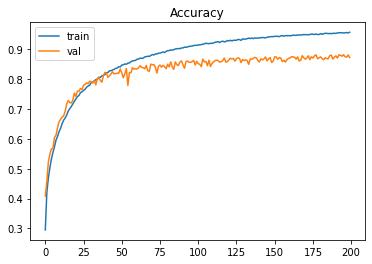

In [21]:
plt.plot(save_acc['train'])
plt.plot(save_acc['val'])
plt.legend(["train", "val"])
plt.title("Accuracy")
plt.savefig('accuracy_regularized.png')


Text(0.5, 1.0, 'Loss')

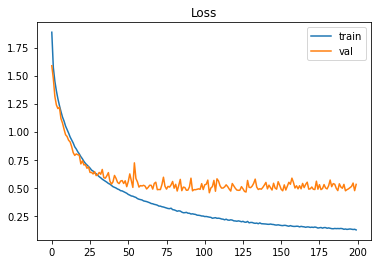

In [18]:
plt.plot(save_loss['train'])
plt.plot(save_loss['val'])
plt.legend(["train", "val"])
plt.title("Loss")


In [12]:
# save resnet model
PATH = './project1_model_v3.pt'
torch.save(model.state_dict(), PATH)

In [13]:
torch.cuda.is_available()

True

In [14]:
device

device(type='cuda')